In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [2]:
from unstructured.partition.pdf import partition_pdf


# Output and file paths
output_path = "data/"
file_path = output_path + "Attention_Is_All_You_Need.pdf"

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # uncomment to save images/tables to specified directory

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic', this so important and effective
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


    chunking_strategy="by_title",
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000,

before this code snipped len(chunks) = 220
now just 12  <b>
super useful for RAG

In [3]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [4]:
len(chunks)

12

In [5]:
chunks[0].to_dict()

{'type': 'CompositeElement',
 'element_id': '3b36ceebe3f84a61e476b7628271c701',
 'text': '3\n\n2023\n\n2\n\n0\n\n2\n\ng u A 2 ] L C . s c [ 7 v 2 6 7 3 0 . 6 0\n\n7\n\n1\n\n:\n\nv\n\narXiv\n\ni\n\nX\n\nr\n\na\n\nProvided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.\n\nAttention Is All You Need\n\nAshish Vaswani∗\n\nGoogle Brain\n\navaswani@google.com\n\nNoam Shazeer∗ Google Brain noam@google.com\n\nNiki Parmar∗ Google Research nikip@google.com\n\nJakob Uszkoreit∗\n\nGoogle Research usz@google.com\n\nLlion Jones∗\n\nGoogle Research llion@google.com\n\nAidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu\n\nŁukasz Kaiser∗ Google Brain lukaszkaiser@google.com\n\nIllia Polosukhin∗ ‡\n\nillia.polosukhin@gmail.com\n\nAbstract\n\nThe dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a dec

In [6]:
chunks[7].metadata.orig_elements

In [7]:
chunks[3].metadata.orig_elements


In [8]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '68662514-1e96-40f5-80ea-2779994293c3',
 'text': '',
 'metadata': {'coordinates': {'points': ((np.float64(486.0),
     np.float64(261.1805555555558)),
    (np.float64(486.0), np.float64(614.7805555555556)),
    (np.float64(664.0), np.float64(614.7805555555556)),
    (np.float64(664.0), np.float64(261.1805555555558))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-07-30T10:39:08',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 4,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiALIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJ

### Separate extracted elements into tables, text, and images

In [9]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [10]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

#### Check what the images look like


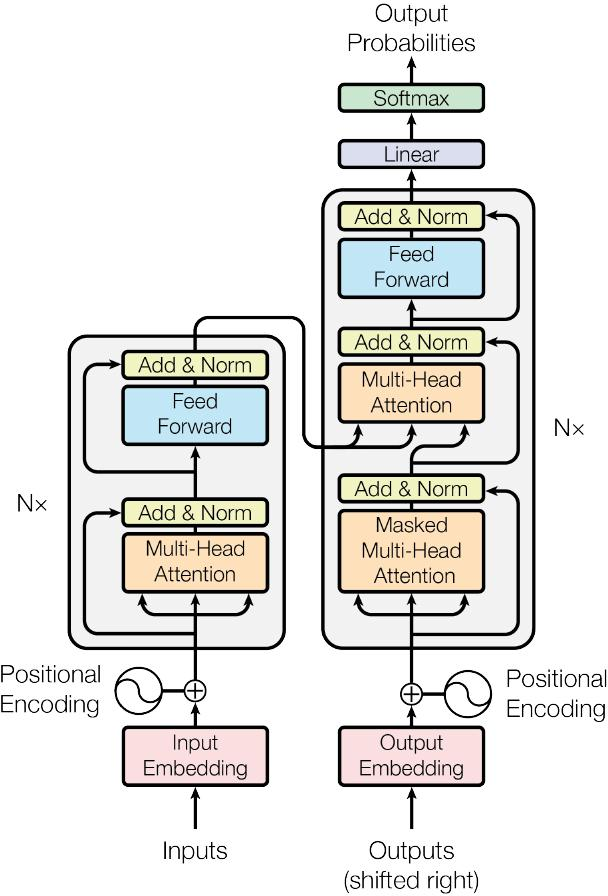

In [11]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [26]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [27]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(temperature=0.5, model="gpt-4o-mini")
summarize_chain = ({"element": lambda x: x}
                   | prompt
                   | model
                   | StrOutputParser()
                   )

In [28]:
print(texts[0])

3

2023

2

0

2

g u A 2 ] L C . s c [ 7 v 2 6 7 3 0 . 6 0

7

1

:

v

arXiv

i

X

r

a

Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.

Attention Is All You Need

Ashish Vaswani∗

Google Brain

avaswani@google.com

Noam Shazeer∗ Google Brain noam@google.com

Niki Parmar∗ Google Research nikip@google.com

Jakob Uszkoreit∗

Google Research usz@google.com

Llion Jones∗

Google Research llion@google.com

Aidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu

Łukasz Kaiser∗ Google Brain lukaszkaiser@google.com

Illia Polosukhin∗ ‡

illia.polosukhin@gmail.com

Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the 

In [29]:
#tables[0].to_dict()
tables

[]

In [31]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [33]:
text_summaries

['The paper presents the Transformer, a novel neural network architecture that relies solely on attention mechanisms, eliminating the need for recurrence and convolutions. This approach outperforms traditional sequence transduction models in machine translation tasks, achieving a BLEU score of 28.4 for English-to-German and 41.8 for English-to-French translations, significantly improving upon previous best results. The Transformer is also noted for its parallelizability and reduced training time, demonstrating strong generalization to other tasks like English constituency parsing. The authors include researchers from Google Brain and Google Research, with equal contributions noted.',
 'Recurrent neural networks, particularly long short-term memory and gated recurrent networks, are established methods for sequence modeling and transduction tasks like language modeling and machine translation. Their sequential nature limits parallelization, especially with longer sequences, though recent

In [35]:
table_summaries

[]

### Image summaries
use gpt-4o-mini to produce the image summaries.

In [34]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = (prompt
         | ChatOpenAI(model="gpt-4o-mini")
         | StrOutputParser())


image_summaries = chain.batch(images)

In [36]:
image_summaries

['The image depicts a block diagram illustrating the architecture of transformers, commonly used in natural language processing.\n\n### Structure Overview:\n1. **Input Layer**:\n   - At the bottom, labeled "Inputs", representing the initial data entering the network.\n   - Includes "Input Embedding", which transforms the raw inputs into a more suitable format for processing.\n   - "Positional Encoding" is connected to the input embedding to inject information about the position of tokens within the input sequence.\n\n2. **Encoder Stack**:\n   - Two main blocks represent the encoder layers, labeled as "Nx".\n   - Each encoder block has several components:\n     - **Multi-Head Attention**:\n       - This section allows the model to focus on different parts of the input sequence simultaneously.\n       - An "Add & Norm" layer follows to stabilize the training by normalizing the outputs.\n     - **Feed Forward**:\n       - A fully connected feed-forward neural network that processes the da

In [37]:
print(image_summaries[1])

The image appears to be a diagrammatic representation of the attention mechanism within the transformer architecture, specifically focusing on the operations involved.

### Components and Structure

1. **Nodes and Operations:**
   - The diagram contains several labeled boxes that represent distinct operations. The boxes are connected by arrows indicating the flow of data.
   - **MatMul:** This operation is represented in purple boxes at the top and bottom of the diagram, indicating matrix multiplication.
   - **SoftMax:** This is depicted in a green box and represents the softmax function, which is often used to convert scores into probabilities.
   - **Mask (opt.):** Shown in a pink box, this optional masking operation can suppress certain parts of the input to maintain attention only on the relevant positions.
   - **Scale:** A yellow box that likely represents the scaling of the scores before the softmax operation.

2. **Input and Output:**
   - Arrows indicate that inputs Q (Query)

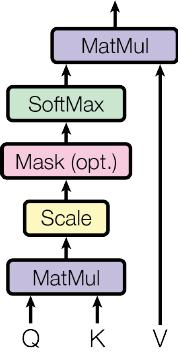

In [40]:
display_base64_image(images[1])

In [38]:
len(image_summaries)

7

## Load data and summaries to vectorstore

### Create the vectorstore

In [42]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

### Load the summaries and link the to the original data

In [44]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
#table_ids = [str(uuid.uuid4()) for _ in tables]
#summary_tables = [
    #Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
#]
#retriever.vectorstore.add_documents(summary_tables)
#retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

### Check retrieval

In [47]:
# Retrieve
chunks = retriever.invoke(
    "what is multihead attention?"
)

In [48]:
chunks

In [49]:
#since we are using chunking, we get chunks of related documents
#since we selected "by_title" as the chunking strategy, we get sections of the documents based on their title
for i, chunk in enumerate(chunks):
    if "CompositeElement" in str(type(chunk)):
        print("\n\nChunk",i)
        for doc in chunk.metadata.orig_elements:
            print(doc.to_dict()["type"], doc.metadata.page_number)





Chunk 0
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
Header 1
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
NarrativeText 1
Title 1
UncategorizedText 1
UncategorizedText 1
UncategorizedText 1
NarrativeText 1
NarrativeText 1
UncategorizedText 1
NarrativeText 1
UncategorizedText 1
NarrativeText 1
NarrativeText 1
NarrativeText 1
Title 1
NarrativeText 1
Title 1
NarrativeText 1
NarrativeText 1
UncategorizedText 1
UncategorizedText 1
NarrativeText 1


Chunk 1
Title 2
NarrativeText 2
NarrativeText 2
NarrativeText 2
NarrativeText 2
Title 2
NarrativeText 2
NarrativeText 2
NarrativeText 2
NarrativeText 2


Chunk 2
Title 2
NarrativeText 2
Footer 2
Image 3
FigureCaption 3
NarrativeText 3
Title 3
NarrativeText 3
NarrativeText 3


Chunk 3
Title 3
NarrativeText 3
Footer 3
UncategorizedText 4
UncategorizedText 4
I

In [50]:
chunks[0].metadata.orig_elements[0].to_dict()

{'type': 'UncategorizedText',
 'element_id': 'b1fc03b7-d497-4a31-a321-e61d678854ea',
 'text': '3',
 'metadata': {'coordinates': {'points': ((np.float64(45.388888888888886),
     np.float64(594.2222222222224)),
    (np.float64(45.388888888888886), np.float64(622.0000000000002)),
    (np.float64(100.94444444444446), np.float64(622.0000000000002)),
    (np.float64(100.94444444444446), np.float64(594.2222222222224))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-07-30T10:39:08',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 1}}

## RAG pipeline

In [53]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [54]:
response = chain.invoke(
    "What is the attention mechanism?"
)

print(response)#from texts

The attention mechanism is a technique used in machine learning models, particularly in natural language processing and computer vision, to allow the model to focus on specific parts of the input data when making predictions or generating outputs. It involves computing weighted representations of the input elements based on their relevance to the current context.

In the context provided, the attention mechanism operates through multiple heads in a multi-head attention setup. Instead of relying on a single attention function, the model linearly projects the queries, keys, and values multiple times (h times) using different learned linear projections. This results in parallel attention operations, which enables the model to capture different aspects of the input information from various representation subspaces at different positions.

The attention function creates a context for each element by considering all other elements, effectively allowing it to learn dependencies and relationsh

In [55]:
response = chain.invoke(
    "Explain Scaled Dot-Product Attention Diagram."
)

print(response)#from images

The Scaled Dot-Product Attention diagram illustrates the process of computing attention using three main components: queries (Q), keys (K), and values (V). 

1. **Linear Transformations**: 
   - The diagram depicts linear layers that transform the input vectors Q, K, and V. Each of these inputs is processed through separate linear layers to produce the corresponding representations.

2. **Concatenation**:
   - After the linear transformations, the outputs are concatenated. This step combines all the transformed Q, K, and V vectors into a single tensor, preparing them for attention computation.

3. **Scaled Dot-Product Attention**:
   - The core component is the Scaled Dot-Product Attention block, where the attention mechanism is applied. This part takes the concatenated vectors and calculates the dot products, scaling them appropriately, and applying the softmax function to derive the attention weights.

4. **Output**:
   - The output from the Scaled Dot-Product Attention block is a we

In [56]:
response = chain.invoke(
    "How to compute the matrix of output? "
)

print(response)#from formulas

To compute the matrix of outputs in the context of Scaled Dot-Product Attention, you use the following formula:

\[ 
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V 
\]

Here's a step-by-step breakdown:

1. **Input Matrices**: Prepare input matrices for queries (Q), keys (K), and values (V).
2. **Dot Product**: Compute the dot products between the query matrix (Q) and the transpose of the key matrix (K^T).
3. **Scaling**: Scale the dot products by dividing by \(\sqrt{d_k}\), where \(d_k\) is the dimension of the keys.
4. **Softmax**: Apply the softmax function to the scaled dot products to obtain the attention weights.
5. **Weighted Sum**: Multiply these attention weights by the value matrix (V) to get the final output matrix.

This results in a weighted sum of the values based on the attention mechanism.


In [63]:
response = chain.invoke(
    "Layer Type is Convolutional so what is the Maximum Path Length?"
)

print(response)#from tables

The maximum path length for the Convolutional layer type is O(logk(n)), where k is the kernel size of convolutions and n is the sequence length.


In [ ]:
response = chain_with_sources.invoke(
    "What is multihead?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)